# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
from itertools import count
import time
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64", worker_id=1, seed=2)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain brains which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.29742813 -1.5
 -0.          0.          7.17024279  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

Set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291


In [6]:
#env.close()

In [7]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### MODEL

In [8]:
### This model is based on Udacity's RL finance model.py and ddpg-bipedal/


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256,
                 fc2_units=256):#,fc3_units=64
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        #self.fc4 = nn.Linear(fc3_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        #self.fc3.weight.data.uniform_(*hidden_init(self.fc1))
        #self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
 
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        #x = F.relu(self.fc3(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256,fc2_units=256):#,fc3_units=64
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        #self.fc3 = nn.Linear(fc2_units, fc3_units)
        #self.fc4 = nn.Linear(fc3_units, 1)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        #self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        #self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """
        Build a critic (value) network that maps
        (state, action) pairs -> Q-values
        :param state: tuple.
        :param action: tuple.
        """
        
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        #x = F.leaky_relu(self.fc2(x))
        #x = F.relu(self.fc3(x))

        return self.fc3(x)

### AGENT

In [11]:
### This actor is based on Udacity's RL finance model.py and ddpg-bipedal/

BUFFER_SIZE = int(1e5)  # replay buffer size                    int(1e5)
BATCH_SIZE = 128        # minibatch size                        128
GAMMA = 0.99            # discount factor                       0.99
TAU = 1e-3              # for soft update of target parameters  1e-3
LR_ACTOR = 2e-4         # learning rate of the actor            1e-4
LR_CRITIC = 2e-4        # learning rate of the critic           1e-3
WEIGHT_DECAY = 0        # L2 weight decay                       0


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
            num_agents (int): number of agents in the environment
        """
        random_seed = 1

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(self.num_agents):                                                  
            self.memory.add(states[i], actions[i], rewards[i], next_states[i], dones[i])  
           #self.memory.add(state, action, reward, next_state, done)                      

        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)
        
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad(): 
            for i, state in enumerate(states):                             
                actions[i, :] = self.actor_local(state).cpu().data.numpy()  
                #action = self.actor_local(state).cpu().data.numpy()            
        self.actor_local.train()      
        if add_noise:
            actions += self.noise.sample()   
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)  
        self.critic_optimizer.step()
        
        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()      
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.15, sigma=0.1):        
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        #dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.normal(loc=0, scale=1) for i in range(len(x))])
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### TRAIN

In [12]:
agent = Agent(state_size, action_size, num_agents)

In [13]:
def ddpg(n_ep=1000, max_Ds=1000, print_at=150): 
    """DDPG Algorithm.
    
    Params
    ======
        n_ep (int): maximum number of training episodes
        max_Ds (int): maximum number of timesteps per episode
        print_at (int): frequency of printing information throughout iteration """
    
    thr = 0.5                     # threshold of scores 
    finished = False      
    
    scores_total = []                                             
    averages = []                                                 
    scores_deque = deque(maxlen=print_at) 

    for i_episode in range(1, n_ep+1):
        env_info = env.reset(train_mode=True)[brain_name]      
        states = env_info.vector_observations                  # current state
        scores = np.zeros(num_agents)                          
        agent.reset()                                          
        
        for t in range(max_Ds):
            actions = agent.act(states)                    # select an action
            env_info = env.step(actions)[brain_name]       # send action to environment
            next_states = env_info.vector_observations     # next state
            rewards = env_info.rewards                     # reward
            dones = env_info.local_done                    # has it finished?
            agent.step(states, actions, rewards, next_states, dones) # take step with agent (including learning)   
            scores += rewards                                        # update score
            states = next_states                                     # roll over the state to next time step
            if np.any(dones):                                        # exit loop if episode finished
                break
        
        average_episode_score = np.mean(scores)         
        scores_deque.append(average_episode_score)      # save most recent score
        scores_total.append(average_episode_score)      # save most recent score
        averages.append(np.mean(scores_deque))          # save most recent averages
        average_score = np.mean(scores_deque)           

        if average_score >= max(averages):                  
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

        
        print('\rEpisode {}\t, Average Score: {:.3f}'.format(i_episode, average_score), end="")
        if i_episode % print_at == 0:

            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, average_score))
                
        if average_score >= thr and finished==False:
            print('\nEnvironment solved in {:d} episodes!\t With average score of: {:.3f}'.format(i_episode, average_score))
            finished = True  
            
    return scores_total, averages

In [14]:
scores, averages = ddpg(n_ep=3000)

Episode 150	Average Score: -0.00404
Episode 300	Average Score: -0.00505
Episode 450	Average Score: -0.00505
Episode 600	Average Score: -0.00202
Episode 750	Average Score: -0.00000
Episode 900	Average Score: -0.00505
Episode 1050	Average Score: 0.00606
Episode 1200	Average Score: 0.016160
Episode 1350	Average Score: 0.04040
Episode 1500	Average Score: 0.07777
Episode 1650	Average Score: 0.09494
Episode 1800	Average Score: 0.08787
Episode 1950	Average Score: 0.19292
Episode 2008	, Average Score: 0.500
Environment solved in 2008 episodes!	 With average score of: 0.500
Episode 2100	Average Score: 0.84545
Episode 2250	Average Score: 0.45555
Episode 2400	Average Score: 0.52020
Episode 2550	Average Score: 0.53131
Episode 2700	Average Score: 0.38383
Episode 2850	Average Score: 0.30202
Episode 3000	Average Score: 0.23939


In [15]:
torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')

### RESULT

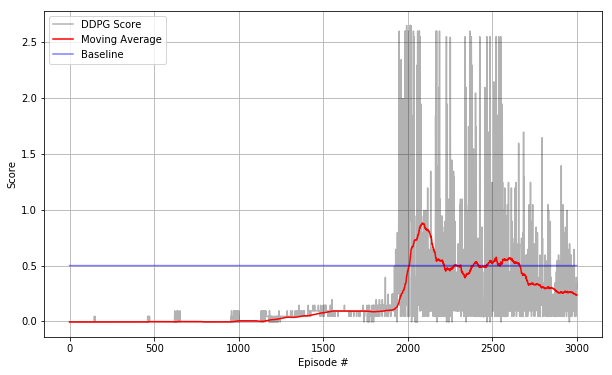

In [18]:
# plot the scores
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, c='k', label='DDPG Score', alpha=0.3)
plt.plot(np.arange(len(scores)), averages, c='r', label='Moving Average')
plt.plot(np.arange(len(scores)), [0.5]*len(scores), c='b', label='Baseline', alpha=0.5)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.grid()
plt.savefig('scores_plot.png')
plt.show()